In [24]:
from pathlib import Path
import requests
import zipfile
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import geopandas as gpd
from shapely import geometry, ops

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib
matplotlib.rcParams.update({"pdf.fonttype":42})

# Download NCSDv2

In [25]:
Path(f'./carbon_data/').mkdir(parents=True, exist_ok=True)

# The pan-Arctic polygon file seems corrupted so we're going to join the regional ones together. Fun!
url = 'https://bolin.su.se/data/ncscd/data/v3/vector/NCSCDv2_regional_polygons_WGS84.zip'

response = requests.get(url)

data_dir = Path('./carbon_data/')

Path(data_dir).mkdir(parents=True, exist_ok=True)

path_to_zip_file = Path(data_dir / 'NCSCDv2_regional_polygons_WGS84.zip.zip')

with open(path_to_zip_file, 'wb') as fd:
    fd.write(response.content)

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

In [67]:
regions = ['Alaska', 'Canada', 'Conusus', 'Europe', 'Iceland', 'Kazaksthan', 'Mongolia', 'Russia', 'Svalbard']

In [70]:
# Greenland seems to be an issue
# But only when loading into ArcMap lol alright

# filtered = [x for x, y in zip(glob.glob('./carbon_data/NCSCDv2_regional_polygons_WGS84/*.shp'), ['Greenland' not in region for region in regions]) if y == True]

filtered = glob.glob('./carbon_data/NCSCDv2_regional_polygons_WGS84/*.shp')

filtered

['./carbon_data/NCSCDv2_regional_polygons_WGS84/NCSCDv2_Conusus_WGS84.shp',
 './carbon_data/NCSCDv2_regional_polygons_WGS84/NCSCDv2_Europe_WGS84.shp',
 './carbon_data/NCSCDv2_regional_polygons_WGS84/NCSCDv2_Kazaksthan_WGS84.shp',
 './carbon_data/NCSCDv2_regional_polygons_WGS84/NCSCDv2_Iceland_WGS84.shp',
 './carbon_data/NCSCDv2_regional_polygons_WGS84/NCSCDv2_Mongolia_WGS84.shp',
 './carbon_data/NCSCDv2_regional_polygons_WGS84/NCSCDv2_Canada_WGS84.shp',
 './carbon_data/NCSCDv2_regional_polygons_WGS84/NCSCDv2_Greenland_WGS84.shp',
 './carbon_data/NCSCDv2_regional_polygons_WGS84/NCSCDv2_Svalbard_WGS84.shp',
 './carbon_data/NCSCDv2_regional_polygons_WGS84/NCSCDv2_Russia_WGS84.shp',
 './carbon_data/NCSCDv2_regional_polygons_WGS84/NCSCDv2_Alaska_WGS84.shp']

## Make one big soil carbon shapefile...this takes a while

In [71]:
gdf_list = pd.concat([
    gpd.read_file(region)
    for region in filtered
])

In [72]:
gdf = gdf_list.pipe(gpd.GeoDataFrame)
gdf.to_file(data_dir / 'all_regions.shp')

<Axes: >

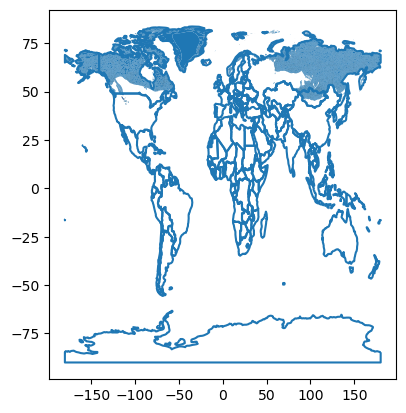

In [73]:
fig, ax = plt.subplots()
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.boundary.plot(ax=ax)
gdf.plot(
    #  s=0.5,
       ax=ax)

In [30]:
# gdf = gpd.read_file(data_dir / 'all_regions.shp')

# Intsersect watershed data with carbon map

In [93]:
a_list = ['100cm','100CM', '30cm','30CM']

In [95]:
'|'.join(a_list)

'100cm|100CM|30cm|30CM'

In [74]:
shed_csv = pd.read_csv('https://raw.githubusercontent.com/jmdelvecchio/arctic-drainage-density/main/watershed_export.csv')
shed_gdf = gpd.GeoDataFrame(
    shed_csv, geometry=gpd.points_from_xy(shed_csv.long, shed_csv.lat), crs='epsg:4326')

In [90]:
shed_carbon = gpd.sjoin(shed_gdf, gdf)

In [97]:
shed_carbon.columns[shed_carbon.columns.str.contains('|'.join(a_list))]

Index(['SOCC_30CM', 'SOCC_100CM', 'SOCM_30CM', 'SOCM_100CM', 'SOCC_30cm',
       'SOCC_100cm', 'kg_C_in_polygon_100cm'],
      dtype='object')

In [98]:
# omg there's 'SOCC_30CM' and 'SOCC_30cm ... clean that ish up 

shed_carbon.loc[shed_carbon['SOCC_30CM'].isna(), 'SOCC_30CM'] = shed_carbon.loc[shed_carbon['SOCC_30CM'].isna(), 'SOCC_30cm'] 
shed_carbon.loc[shed_carbon['SOCC_100CM'].isna(), 'SOCC_100CM'] = shed_carbon.loc[shed_carbon['SOCC_100CM'].isna(), 'SOCC_100cm'] 



<Axes: >

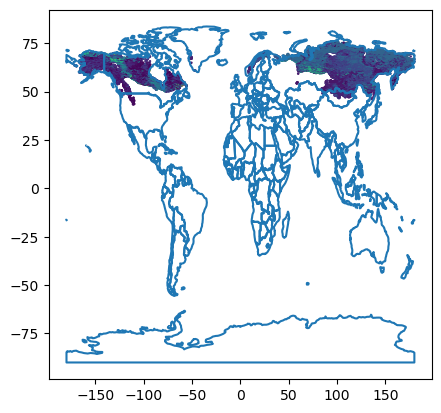

In [99]:
fig, ax = plt.subplots()
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.boundary.plot(ax=ax)
# gdf.plot(
#     # column='SOCC_100CM', s=0.5, 
#     ax=ax)
# shed_gdf.plot(
#     # column='SOCC_100CM', s=0.5, 
#     ax=ax)
shed_carbon.plot(
    column='SOCC_100CM', s=0.5, 
    ax=ax)

<Axes: ylabel='Frequency'>

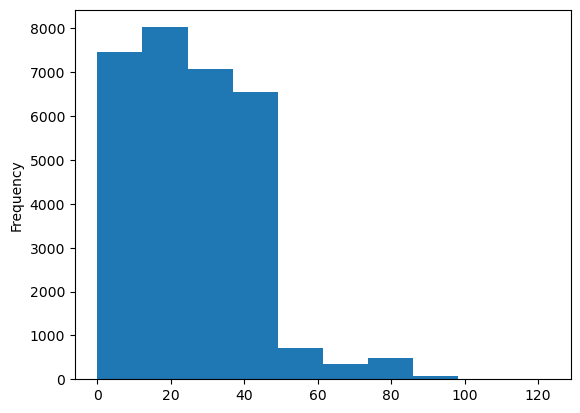

In [100]:
shed_carbon['SOCC_100CM'].plot.hist()

<Axes: ylabel='Frequency'>

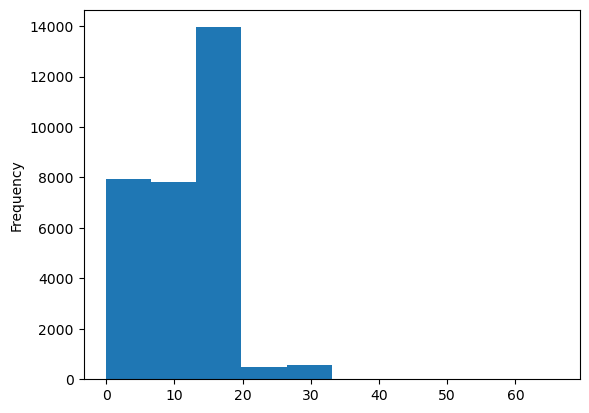

In [101]:
shed_carbon['SOCC_30CM'].plot.hist()

# Number of eroding pixels per degree for each watershed

In [102]:
shed_csv.columns

Index(['Unnamed: 0', 'long', 'lat', 'HYBAS_ID', 'segment_ct', 'flow_acc',
       'relief', 'map_mean', 'mat_mean', 'ndvi_mean', 'glaciated', 'EXTENT',
       'DD', 'geometry'],
      dtype='object')

In [103]:
permafrost = shed_gdf.loc[shed_gdf['EXTENT'] != 'No permafrost']
permafrost

,Unnamed: 0,long,lat,HYBAS_ID,segment_ct,flow_acc,relief,map_mean,mat_mean,ndvi_mean,glaciated,EXTENT,DD,geometry
821,66980,88.464202,27.666123,4100842710,26194,170417,3902.000000,777.818634,3.959487,6307.076704,Not glaciated,Discontinuous,0.153705,POINT (88.46420 27.66612)
1004,71082,98.620847,28.211950,4100821180,30454,207516,2408.000000,758.171310,4.146987,7177.744231,Not glaciated,Sporadic,0.146755,POINT (98.62085 28.21195)
1032,68915,93.147218,28.289187,4100823040,31562,210012,3093.000000,596.292640,7.556557,7132.546750,Not glaciated,Discontinuous,0.150287,POINT (93.14722 28.28919)
1036,71006,98.281841,28.317856,4101460030,24313,171104,1964.000000,751.182086,3.648098,7140.765050,Not glaciated,Sporadic,0.142095,POINT (98.28184 28.31786)
1059,68490,92.873130,28.418211,4100816320,20596,143471,2412.000000,338.098856,2.563755,6027.151987,Not glaciated,Discontinuous,0.143555,POINT (92.87313 28.41821)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69585,27677,111.634358,76.379969,3100007040,126519,956611,155.677142,191.503388,-15.314763,6591.832819,MIS6,Continuous,0.132258,POINT (111.63436 76.37997)
69586,25258,100.338208,76.380954,3100006290,45170,430888,102.206483,233.798298,-14.884254,6008.606693,LGM,Continuous,0.104830,POINT (100.33821 76.38095)
69588,27372,110.472404,76.569198,3100034850,145563,1071601,265.136874,198.286060,-15.368669,6593.252130,MIS6,Continuous,0.135837,POINT (110.47240 76.56920)
69589,27268,109.534411,76.688592,3100006950,85112,746478,49.878629,201.078769,-15.199847,6508.737281,MIS6,Continuous,0.114018,POINT (109.53441 76.68859)


In [104]:
regression_model = LinearRegression()
  
x = shed_gdf['mat_mean'].values.reshape(-1, 1)

y = shed_gdf['DD'].values.reshape(-1, 1)

# Fit the data(train the model)
regression_model.fit(x, y)
  
# Predict
y_predicted = regression_model.predict(x)
  
# model evaluation
mse=mean_squared_error(y,y_predicted)
  
rmse = np.sqrt(mean_squared_error(y, y_predicted))
r2 = r2_score(y, y_predicted)
  
# printing values
print('Slope:' ,regression_model.coef_)
print('Intercept:', regression_model.intercept_)
print('MSE:',mse)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[0.00145384]]
Intercept: [0.14366975]
MSE: 0.0002206525509468432
Root mean squared error:  0.014854378174357996
R2 score:  0.3984076719464281


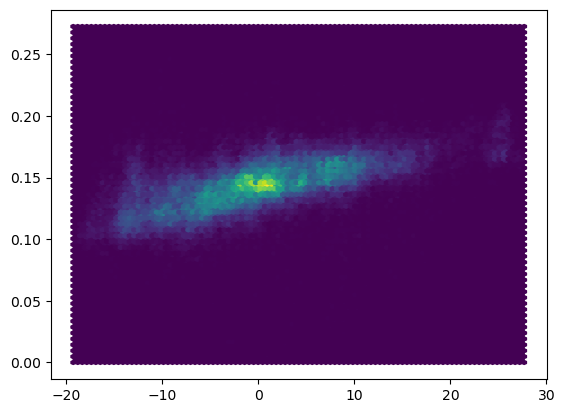

In [105]:
plt.hexbin(x,y)

<Axes: ylabel='Frequency'>

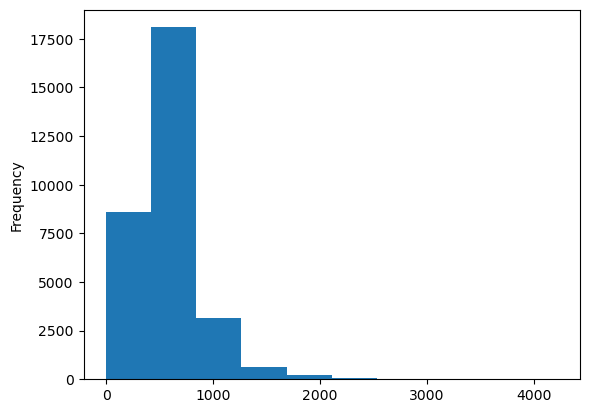

In [106]:
pct_pix_per_deg = regression_model.coef_[0]

shed_carbon['eroding_pixels'] = shed_carbon['flow_acc'] * pct_pix_per_deg

shed_carbon['eroding_pixels'].plot.hist()

# Carbon content in eroding pixel area

In [107]:
shed_carbon['kg_C_in_eroding_pixels'] = shed_carbon['eroding_pixels'] * shed_carbon['SOCC_100CM'] * 90
# pixels are 90 m2
shed_carbon['kg_C_in_eroding_pixels'].sum()

43494095349.23236

In [108]:
gdf['kg_C_in_polygon_100cm'] = gdf['AREA'] * gdf['SOCC_100CM']

shed_carbon['kg_C_in_eroding_pixels'].sum() / gdf['kg_C_in_polygon_100cm'].sum() * 100

0.009582988927653927

In [109]:
# Metric tons C divided by mass C emitted from a typical passenger car in a year
# https://www.epa.gov/greenvehicles/greenhouse-gas-emissions-typical-passenger-vehicle

co2_emissions_epa_kg = 4600 # typical passenger vehicle emits 4.6 metric tons CO2 in a year

co2_equivalent_shed_carbon = shed_carbon['kg_C_in_eroding_pixels'].sum() * (44/12) # molecular weight of CO2/carbon

co2_equivalent_shed_carbon / co2_emissions_epa_kg

34669206.43779391